# GTD prediction model
Use attack type, weapons used, description of the attack, etc. to build a model that can predict what group may have been responsible for an incident.

* The prediction model used: random forest classifier
* special feature: spatial clustering to identify terrorism hotspots
    * terrorism can crop up in regions that are not well described by borders
    * used latitude and longitude of attacks to identify high density areas of attacks
    * assigned every attack to a hotspot
* data selection: 
    * did not use 30% or greater missing features
    * combined parameters to reduce feature space
* memory workarounds:
    * predictive model iterated on subsets of data
    * optimized tree depth

  

In [1]:
# Load the library with the iris dataset
from sklearn.datasets import load_iris
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
# Load pandas
import pandas as pd
# Load numpy
import numpy as np
# Set random seed
np.random.seed(0)
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
mycol=pd.read_csv("rawdata/col_index.txt",delim_whitespace=1)
myindex=list(np.array([int(i) for i in list(mycol)])-1)+[13,14] #add latitude longitude

In [3]:
df = pd.read_csv("rawdata/globalterrorismdb_0617dist.csv",encoding='ISO-8859-1',usecols=myindex)

# Data Inspection and Cleaning

## a) convert datatypes to category, numeric, integer 

In [4]:
convert_to_cat=["extended",
                "country_txt","region_txt","provstate",
                "crit1","crit2","crit3","doubtterr",
                "suicide","attacktype1_txt","targtype1_txt","natlty1_txt",
                "gname","guncertain1","individual","weaptype1_txt",
               "property","ishostkid",
                "INT_LOG","INT_IDEO","INT_MISC","INT_ANY"]


convert_to_float=["extended","nkill","nwound","latitude","longitude"]

In [5]:
df[['iday', 'imonth','iyear']] = df[['iday', 'imonth','iyear']].astype(int)

for thecol in convert_to_cat:
    df[thecol]=df[thecol].astype('category')
for thecol in convert_to_float:
    df[thecol]=df[thecol].astype(float)

## b) calculate new columns from data

In [6]:
df["datetime"]=pd.to_datetime(df["iday"],df["imonth"],df["iyear"])
df=df.drop('iday',axis=1)

In [7]:
#df['imonth']=df['imonth'].astype('category')
#df['iyear']=df['iyear'].astype('category')

In [8]:
df['nwound'].fillna(0).astype(int)
df['nkill'].fillna(0).astype(int)
df['ncasualities']=df['nkill']+df['nwound']
df=df.drop(['nwound','nkill'], axis=1)

## c) summarize data

In [9]:
dfsumcat=df.describe(include=['category'])
dfsumcat.iloc[:,0:10]

,country_txt,region_txt,provstate,crit1,crit2,crit3,doubtterr,suicide,attacktype1_txt,targtype1_txt
count,170350,170350,155848,170350,170350,170350,170350,170350,170350,170350
unique,205,12,2494,2,2,2,3,2,9,22
top,Iraq,Middle East & North Africa,Baghdad,1,1,1,0,0,Bombing/Explosion,Private Citizens & Property
freq,22130,46511,7238,168381,169155,149877,129942,164580,83073,39994


In [10]:
dfsumcat.iloc[:,10:20]

,natlty1_txt,gname,guncertain1,individual,weaptype1_txt,property,ishostkid,INT_LOG,INT_IDEO,INT_MISC
count,168956,170350,169971,170350,170350,170350,170172,170350,170350,170350
unique,213,3454,2,2,12,3,3,3,3,3
top,Iraq,Unknown,0,0,Explosives/Bombs/Dynamite,1,0,-9,-9,0
freq,21625,78306,155633,169927,86704,90019,157411,87497,87629,149964


In [11]:
dfsumnum=df.describe(include=[np.number])
dfsumnum

,eventid,iyear,imonth,extended,latitude,longitude,ncasualities
count,1.703500e+05,170350.000000,170350.000000,170350.000000,165744.000000,165744.000000,154524.000000
mean,2.001776e+11,2001.709997,6.474365,0.043634,23.399774,26.350909,5.312327
std,1.314444e+09,13.144146,3.392364,0.204279,18.844885,58.570068,40.798412
min,1.970000e+11,1970.000000,0.000000,0.000000,-53.154613,-176.176447,0.000000
25%,1.990053e+11,1990.000000,4.000000,0.000000,11.263580,2.396199,0.000000
50%,2.007121e+11,2007.000000,6.000000,0.000000,31.472680,43.130000,1.000000
75%,2.014023e+11,2014.000000,9.000000,0.000000,34.744167,68.451297,4.000000
max,2.017013e+11,2016.000000,12.000000,1.000000,74.633553,179.366667,8749.000000


### missing data analysis

In [12]:
df.isnull().sum()/len(df)<0.30 #make sure at least 70 percent of data is present!
#terror_data['injuries'] = terror_data['injuries'].fillna(0).astype(int)
df.isnull().sum()/len(df)

eventid            0.000000
iyear              0.000000
imonth             0.000000
extended           0.000000
country_txt        0.000000
region_txt         0.000000
provstate          0.085131
latitude           0.027038
longitude          0.027038
crit1              0.000000
crit2              0.000000
crit3              0.000000
doubtterr          0.000000
suicide            0.000000
attacktype1_txt    0.000000
targtype1_txt      0.000000
natlty1_txt        0.008183
gname              0.000000
guncertain1        0.002225
individual         0.000000
weaptype1_txt      0.000000
property           0.000000
ishostkid          0.001045
INT_LOG            0.000000
INT_IDEO           0.000000
INT_MISC           0.000000
INT_ANY            0.000000
datetime           0.000000
ncasualities       0.092903
dtype: float64

## d)  Data Imputation

In [13]:
col_many_cat=df.select_dtypes(include=['category']).apply(lambda x: len(x.unique())>12)
#1. data has many categories: label na data as missing
df_cat_hi=df.select_dtypes(include=['category']).ix[:,col_many_cat==True] 
df_cat_hi=df_cat_hi.apply(lambda x: x.cat.add_categories(['missing']).fillna('missing'))
#2  data has few categories:impute na data as most frequent
df_cat_lw=df.select_dtypes(include=['category']).ix[:,col_many_cat==False] 
df_cat_lw=df_cat_lw.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [14]:
#3  data is numerical:impute na data as median (some of the data is skewed)
df_num=df[["extended","ncasualities","iyear","imonth","latitude","longitude"]].apply(lambda x:x.fillna(x.median()))

In [15]:
df = pd.concat([df_num,df_cat_hi,df_cat_lw],axis=1)

In [16]:
df.isnull().sum()/len(df)

extended           0
ncasualities       0
iyear              0
imonth             0
latitude           0
longitude          0
country_txt        0
provstate          0
targtype1_txt      0
natlty1_txt        0
gname              0
region_txt         0
crit1              0
crit2              0
crit3              0
doubtterr          0
suicide            0
attacktype1_txt    0
guncertain1        0
individual         0
weaptype1_txt      0
property           0
ishostkid          0
INT_LOG            0
INT_IDEO           0
INT_MISC           0
INT_ANY            0
dtype: float64

# modify data 

In [17]:
df["ncasualities"]=list(np.log10(np.array((df["ncasualities"]))+1))
setcrit=zip(list(df["crit1"]),list(df["crit2"]),list(df["crit3"]))

In [18]:
df["critall"]=[str(s[0])+str(s[1])+str(s[2]) for s in setcrit]

In [19]:
df['critall']=df['critall'].astype('category')

# Identify Spatial Terrorism Hot Zones With Clustering

In [20]:
from sklearn.cluster import DBSCAN

In [21]:
from geopy.distance import great_circle

In [22]:
from shapely.geometry import MultiPoint

In [23]:
# Define coordinates 
coords = df.as_matrix(columns=['latitude', 'longitude'])

In [24]:
subcoords=coords

In [25]:
kms_per_radian = 6371.0088 #haversine needs radians
epsilon = 160 / kms_per_radian # otherwise outside of cluster (100 miles)
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(subcoords))

In [26]:
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([subcoords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 456


In [27]:
df["terrorism_hotspot"]=list(cluster_labels)

In [28]:
df["terrorism_hotspot"]=df["terrorism_hotspot"].astype('category')

### e) refine model and drop columns that are adding noise

In [29]:
df=df.drop(["individual","crit1","suicide","ishostkid","latitude","longitude","crit2","crit3","extended"],axis=1)

# Create Training and Testing Data Sets

### a. splice out data that has no group assigned to the attack

In [30]:
dfgu=df.ix[df['gname']=='Unknown',:] #group unknown
dfgk=df.ix[df['gname']!='Unknown',:]#group known

In [31]:
len(df)==len(dfgu)+len(dfgk) #check that this is all the data

True

### b. factorize categorical data

In [32]:
# Create a list of the feature column's names
dfgk_cat=dfgk.select_dtypes(include=['category']).apply(lambda x: pd.factorize(x)[0])


In [33]:
dfgk_num=dfgk.select_dtypes(exclude=['category'])
dfgk_fac = pd.concat([dfgk_cat,dfgk_num], axis=1)

### c. split data training and test  sets

In [34]:
# randomly label some rows as training and some as test data.
dfgk_fac['is_train'] = np.random.uniform(0, 1, len(dfgk_fac)) <= .70 #is train? 1/0 (75% training)


In [35]:
train, test = dfgk_fac[dfgk_fac['is_train']==True], dfgk_fac[dfgk_fac['is_train']==False]

In [36]:
# Show the number of observations
train=train.drop("is_train",axis=1)
test=test.drop("is_train",axis=1)
print('total attacks in the training data:', len(train))
print('total attacks in the test data:',len(test))


('total attacks in the training data:', 64466)
('total attacks in the test data:', 27578)


In [37]:
y=train["gname"]

In [38]:
# Create a list of the feature column's names
features = train.drop('gname',axis=1).columns[:]

# Train Model

In [39]:
# generated a random forest classifer (clf)
clf = RandomForestClassifier(n_jobs=4,max_depth=15,random_state=0,warm_start=False,oob_score=False,n_estimators=30)
# training the classifer on the terrorist group names
clf.fit(train[features],y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=4,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

# Test Model on Data Piecewise to Avoid Memory Issues

### test subset of training data

pull of a subset 

In [40]:
len(test)

27578

In [41]:
div20=27500
mytest=test.iloc[0:div20]

write function that will predict given index of attack

In [42]:
def predset(index_attack):
    return clf.predict(mytest[features].iloc[index_attack,:])

create an index set for attacks (20 in each)

In [43]:
mysets=np.reshape(np.arange(0,div20),(div20/20,20)) #test 20 at a time
preds=np.zeros(div20)

have the model predict the group responsible

In [44]:
for set_index in mysets:
    preds[set_index]=predset(set_index)

see how accurate the predictions were

# Evaluate Model

In [45]:
accuracy = accuracy_score(mytest['gname'], preds)

In [46]:
accuracy

0.79123636363636363

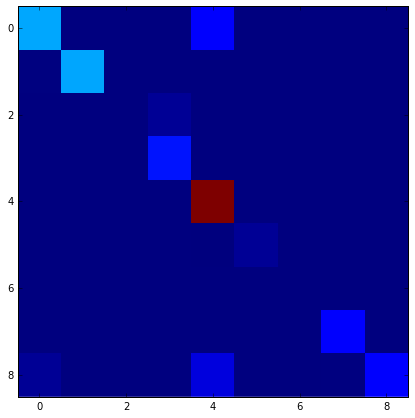

In [47]:
# Create confusion matrix
#conf=pd.crosstab(mytest['gname'], preds, rownames=['Actual Group Name'], colnames=['Predicted Group Name'])
plt.rcParams['figure.figsize'] = [12, 7]
conf = confusion_matrix(mytest['gname'],preds)
plt.imshow(conf[1:10,1:10],interpolation='None',)


In [48]:
#list(zip(train[features], clf.feature_importances_))

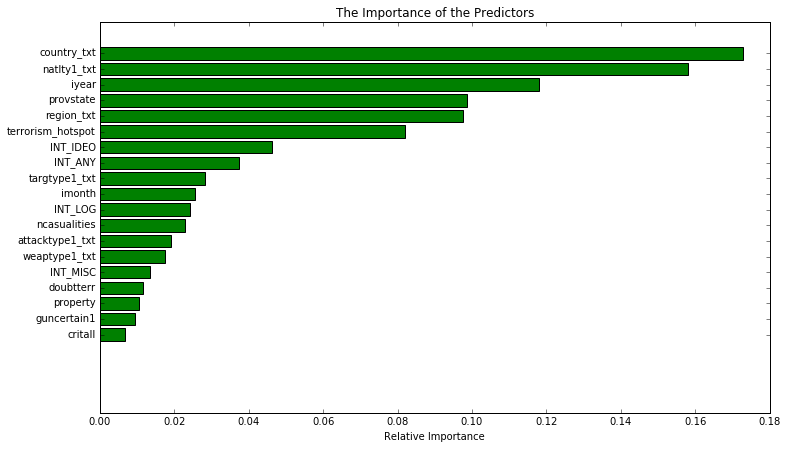

In [49]:
importances = clf.feature_importances_
findex = np.argsort(importances)
plt.rcParams['figure.figsize'] = [12, 7]
plt.figure(1)
plt.title('The Importance of the Predictors')
plt.barh(range(len(findex)), importances[findex], color='g', align='center')
plt.yticks(range(len(findex)), features[findex])
plt.xlabel('Relative Importance')

#### Hack to Give us OOB score

In [50]:
# generated a random forest classifer (clf)
clf = RandomForestClassifier(n_jobs=4,max_depth=15,random_state=0,warm_start=True,oob_score=True,n_estimators=1)
# training the classifer on the terrorist group names
clf.fit(train[features].iloc[0:2000],y[0:2000])

/home/ej/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=4,
            oob_score=True, random_state=0, verbose=0, warm_start=True)

In [51]:
1-clf.oob_score_

0.80600000000000005

This is close to what we found when we tested our model on data it had never seen before.